In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# from src.tools import Dataset
from src.dataset import Dataset
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
dataset = Dataset(scaler=StandardScaler)

# Modeling
___

After having performed exploratory data analysis and data preprocessing in our previous notebook, we're ready to start training our machine learning model. In this notebook we will compare the performance of various models like Logistic Regression, Random Forest, Support Vector Machines (SVM), and Gradient Boosting algorithms (XGBoost). We will compare the performance of all 4 models and select the highest performing model. We will then tune the hyperparamters of our top model, and lastly we will use it to predict on new data (holdout test set).

### Metrics Discussion

We will begin our modeling process by determing ideal metrics to base the model performance. To accomplish that, let's take a look at the distribution of the target variable itself. This is an important step in the process as using the wrong metric can provide misleading results. In some cases, the target variable can be imbalanced, meaning most of the instances belong to a single or few classes compared to the rest. When dealing with imbalanced classes, it's important to look beyond accuracy and consider metrics that specifically focus on the performance of the minority class. *Precision, recall, F1-score, AUPRC*, and *AUC* are commonly used metrics in such cases.

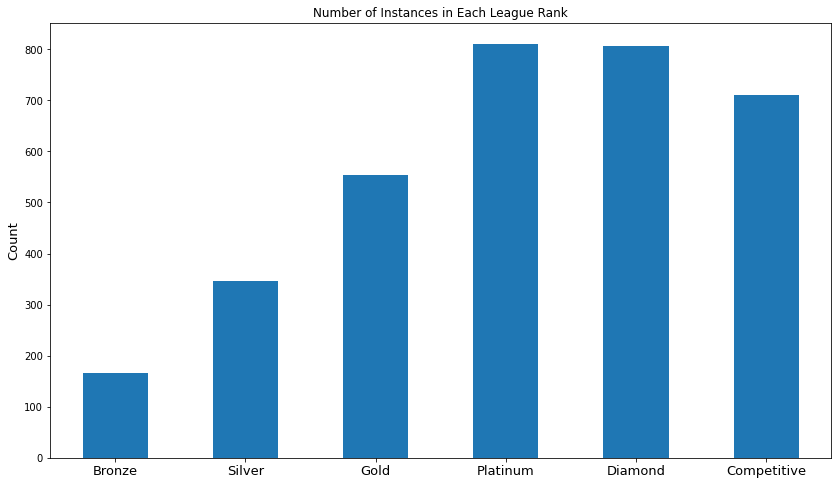

In [3]:
df = dataset.get_data()
classes = [
    'Bronze', 'Silver', 'Gold', 'Platinum', 'Diamond', 
    'Competitive' #'Master', 'GrandMaster', 'Professional' 
]
ax = df.LeagueIndex.value_counts().sort_index().plot(
    kind='bar',
    figsize=(14,8),
    title="Number of Instances in Each League Rank"
)

ax.set_ylabel("Count", size=13)
ax.set_xticklabels(classes, rotation=360, size=13);

As can be seen from the bar chart above, the distribution of classes within the target variable is left skewed, `Platinum` and `Diamond` classes are dominant. This then means we cannot rely on *accuracy* alone as the model can achieve high accuracy on the majority class, while performing poorly on the minority class. For this particular dataset, we will use weighted `Precision`, `Recall`, and `F1-Score` which can be calculated for each individual class using the concepts of true positives, false positives, and false negatives. These metrics provide insights into the performance of the model for each class separately. For multiclass problems, precision, recall, and F1-score are usually calculated using a one-vs-rest or one-vs-one approach, depending on the specific multiclass strategy.

In [4]:
# from imblearn.over_sampling import RandomOverSampler

X_train, X_test, y_train, y_test = dataset.get_train_test_data(scaled=True, test_size=0.2)

# # Create an instance of the RandomOverSampler
# oversampler = RandomOverSampler(random_state=42)

# # Apply oversampling to the training data
# X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)

Next we will create some functions to calculate and display key metrics of the model. We will also make use of a confusion matrix to better assess the kind of classifications the model makes. If the model performs poorly, we can see where the model tends to miss classify players ranks.

In [5]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

def get_metrics(ytrue, ypred):
    '''
        Calculates the key metrics of the results using concepts of true positives,
        true negatives, false positives, and false negative.
    '''
    accuracy = accuracy_score(ytrue, ypred)
    precision = precision_score(ytrue, ypred, average='weighted', zero_division=0)
    recall = recall_score(ytrue, ypred, average='weighted', zero_division=0)
    F1score = f1_score(ytrue, ypred, average='weighted', zero_division=0)
    
    metrics = {
        'accuracy' : accuracy,
        'Precision': precision,
        'Recall'   : recall,
        'F1score'  : F1score
    }
    return metrics

def print_metrics(ypredTrain=None, ytrueTrain=y_train, 
                  ypredTest=None, ytrueTest=y_test):
    '''
        Prints the key metrics of the results.
    '''
  
    trainmetrics = get_metrics(ytrueTrain, ypredTrain)
    
    if ypredTest is not None:
        testmetrics = get_metrics(ytrueTest, ypredTest)


    print('{:<12} | {:<8}  | {:<8}'.format('Metric', 'Value', 'Dataset'))
    print('_'*34)
    print('{:<12} | {:<8}  | {:<8}'.format('Accuracy', round(trainmetrics['accuracy'], 4), 'train'))
    print('{:<12} | {:<8}  | {:<8}'.format('Precision', round(trainmetrics['Precision'], 4), 'train'))
    print('{:<12} | {:<8}  | {:<8}'.format('Recall', round(trainmetrics['Recall'], 4), 'train'))
    print('{:<12} | {:<8}  | {:<8}'.format('F1Score', round(trainmetrics['F1score'], 4), 'train'))
    print('_'*34)
    
    if ypredTest is not None:
        print('{:<12} | {:<8}  | {:<8}'.format('Accuracy', round(testmetrics['accuracy'], 4), 'test'))
        print('{:<12} | {:<8}  | {:<8}'.format('Precision', round(testmetrics['Precision'], 4), 'test'))
        print('{:<12} | {:<8}  | {:<8}'.format('Recall', round(testmetrics['Recall'], 4), 'test'))
        print('{:<12} | {:<8}  | {:<8}'.format('F1Score', round(testmetrics['F1score'], 4), 'test'))
        
        
def plot_heatmap(ytrue, ypred):
    cm = confusion_matrix(ytrue, ypred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=classes)
    disp.plot()
    plt.show()

### Model Training and Evaluation
___

Now that we have selected the metrics we will be using, we can begin to train our selected models. We will also evaluate and compare the performance of all models and select a final model that will be used for the rest of our project.

In [6]:
# from imblearn.combine import SMOTEENN
# from imblearn.under_sampling import RandomUnderSampler

# # Split the dataset into features (X) and target variable (y)
# scaled_data = dataset.get_data(True)
# X = scaled_data.drop('LeagueIndex', axis=1)
# y = scaled_data.LeagueIndex

# # Create an instance of undersampler
# under_sampler = RandomUnderSampler()  # Adjust the sampling_strategy as desired

# # Create an instance of oversampler
# over_sampler = SMOTEENN()

# # Apply undersampling to the majority class samples
# X_under, y_under = under_sampler.fit_resample(X, y)

# # Apply oversampling to the minority class samples
# X_resampled, y_resampled = over_sampler.fit_resample(X_under, y_under)

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

SEED = 42

# Instantiate the models
rfr = RandomForestClassifier(
    random_state=SEED
)

logreg = LogisticRegression(
    solver='liblinear', 
    random_state=SEED
)

svc = SVC(
    kernel='linear', 
    random_state=SEED
)

xgb = XGBClassifier(
    objective='multi:softmax',  # objective function for multiclass classification
    num_class=y_train.nunique(),  # number of classes in the target variable
    learning_rate=0.1,  # learning rate
    n_estimators=100,  # number of trees in the model,
    random_state=SEED
)

In [11]:
# Train the models
rfr.fit(X_train, y_train)
rfr_pred = rfr.predict(X_train)

logreg.fit(X_train, y_train)
logreg_pred = logreg.predict(X_train)

svc.fit(X_train, y_train)
svc_pred = svc.predict(X_train)

# We subtract 1 during fitting because XGB model expects variables to be encoded from [0, N].
# We then add 1 to its predictions to match the labels of the true data.
xgb.fit(X_train, y_train - 1) 
xgb_pred = xgb.predict(X_train) + 1

In [13]:
# Compare the models
print('Random Forest\n')
print_metrics(ypredTrain=rfr_pred,
              ypredTest=rfr.predict(X_test))

print('\nLogistic Regressor\n')
print_metrics(ypredTrain=logreg_pred,
              ypredTest=logreg.predict(X_test))

print('\nSupport Vector Machines (SVM)\n')
print_metrics(ypredTrain=svc_pred,
              ypredTest=svc.predict(X_test))

print('\nXGB Boost Classifier\n')
print_metrics(ypredTrain=xgb_pred,
              ypredTest=xgb.predict(X_test))

Random Forest

Metric       | Value     | Dataset 
__________________________________
Accuracy     | 1.0       | train   
Precision    | 1.0       | train   
Recall       | 1.0       | train   
F1Score      | 1.0       | train   
__________________________________
Accuracy     | 0.408     | test    
Precision    | 0.409     | test    
Recall       | 0.408     | test    
F1Score      | 0.4067    | test    

Logistic Regressor

Metric       | Value     | Dataset 
__________________________________
Accuracy     | 0.4488    | train   
Precision    | 0.4522    | train   
Recall       | 0.4488    | train   
F1Score      | 0.4328    | train   
__________________________________
Accuracy     | 0.461     | test    
Precision    | 0.4772    | test    
Recall       | 0.461     | test    
F1Score      | 0.4441    | test    

Support Vector Machines (SVM)

Metric       | Value     | Dataset 
__________________________________
Accuracy     | 0.4602    | train   
Precision    | 0.4703    | train   
R

#### Analyzing The Metrics

Let's now take a moment to make a preliminary assesment of each of the models' performance.

**Random Forest**:

* Training accuracy, precision, recall, and F1 score are all perfect (1.0), indicating that the model has achieved perfect performance on the training data.
* Test accuracy, precision, recall, and F1 score are relatively low (around 0.408), suggesting that the model is not able to generalize well to unseen data. This indicates a potential overfitting issue.

**Logistic Regression**:

* Training accuracy, precision, recall, and F1 score are relatively low (around 0.4488), indicating that the model's performance on the training data is moderate.
* Test accuracy, precision, recall, and F1 score are slightly higher than the training metrics (around 0.461), suggesting that the model is generalizing slightly better to the test data compared to the training data.

**Support Vector Machines (SVM):**

* Training accuracy, precision, recall, and F1 score are similar to the Logistic Regression model (around 0.4602), indicating comparable performance on the training data.
* Test accuracy, precision, recall, and F1 score are also similar to the Logistic Regression model (around 0.4595), suggesting similar generalization performance on the test data.

**XGBoost Classifier:**

* Training accuracy, precision, recall, and F1 score are extremely high (around 0.9823), indicating near-perfect performance on the training data.
* Test accuracy, precision, recall, and F1 score are considerably lower (around 0.2504), indicating poor generalization performance on the test data. This suggests a significant overfitting issue with the model.

Considering the base performance of these models, it is challenging to choose a single model to optimize based solely on their base structure. All models exhibit suboptimal performance on the test set, indicating a need for further improvement. If we had to choose one of these models for optimization, the ideal candidate would be the Logistic Regression model or the Random Forest Regressor. They show slightly better performance compared to the other models, with relatively higher and steady precision and F1 scores on the test set.

However, it's important to note that these models are currently underperforming, and there is a clear need for hyperparameter optimization, feature selection, or potentially exploring other algorithms to improve their performance. Optimization techniques such as grid search or random search can be used to tune the hyperparameters of the chosen model to improve its performance. Additionally, considering techniques like feature selection or engineering, ensemble methods, or even trying more advanced models could also be beneficial in enhancing the predictive power of the model.

We also make an important note about the dataset as a whole. Based on the XGB and Random Forest scores, it indicates overfitting as we mentioned on the analyis of their metrics. Another potential factor would the imbalance  on the dataset. The amount of players on `Bronze` and `Silver` ranks combined would allow for better distribution but as is, hinders the ability of models to determine a pattern. One method I attempted to use was oversampling of the minority class, undersampling of the majority class and hybrid sampling. All three methods did not significantly improve the performance of the models and we chose to not pursue that method further. We will instead attempt to optimize the hyperparameters of the best models so far.

## Optimization and Validation
___

In the previous section, we analyzed the performance of 4 base models. Althought the results showed suboptimal performance across all models, the Logistic Regression and Random Forest models seem to be more promising. In this section we will be performing hyperparameter optimization of our best model to determine the best parameters that allows us to achieve the best and most robust results possible, we will acomplish this task using cross-validation techniques. It is important to reiterate the fact the our target class, `LeagueIndex`, is imbalanced, and we have previously mentioned cannot rely on accuracy alone to determine model performance. For this next stage we will create a custom scorer that combines a **balanced accuracy score** and weighted F1-score to rank the performance of the model accross multiple iterations.

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, balanced_accuracy_score

model = LogisticRegression(max_iter=10000)

# Define custom scoring metrics
scoring_metrics = {
    'Weighted F1-score': make_scorer(f1_score, average='weighted'),
    'Balanced accuracy': make_scorer(balanced_accuracy_score)
}

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.1, 1.0, 10.0, 50, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# Create the GridSearchCV object
grid_search = GridSearchCV(model, param_grid, scoring=scoring_metrics, 
                           refit='Weighted F1-score', cv=5)

In [24]:
# Perform grid search
grid_search.fit(X_train, y_train)

# Get the best scores and parameters
best_scores = grid_search.best_score_
best_params = grid_search.best_params_
best_logreg = grid_search.best_estimator_

In [25]:
# Print the results
for metric, score in best_params.items():
    print(f'Best {metric}: {score}')
print(f'Best score: {round(best_scores, 4) * 100}%')

Best C: 50
Best penalty: l2
Best solver: saga
Best score: 43.74%


In [28]:
# Optimize RFR
model = RandomForestClassifier(random_state=42)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [10, 100, 500, 1000],  # Number of trees in the forest
    'max_depth': [None, 0, 5, 10],       # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],    # Minimum number of samples required at each leaf node
    'max_features': ['sqrt', 1, 2, 3], # Number of features to consider when looking for the best split
}

# Create the GridSearchCV object
grid_search = GridSearchCV(
    model, 
    param_grid, 
    scoring=scoring_metrics, 
    refit='Weighted F1-score', 
    cv=5
)

In [ ]:
# Perform grid search
grid_search.fit(X_train, y_train)

# Get the best scores and parameters
best_scores = grid_search.best_score_
best_params = grid_search.best_params_
best_rfr = grid_search.best_estimator_

In [30]:
for metric, score in best_params.items():
    print(f'Best {metric}: {score}')
print(f'Best score: {round(best_scores, 4) * 100}%')

Best max_depth: None
Best max_features: 3
Best min_samples_leaf: 4
Best min_samples_split: 10
Best n_estimators: 100
Best score: 43.830000000000005%


In [31]:
rfr_pred = best_rfr.predict(X_train)
logreg_pred = best_logreg.predict(X_train)

In [32]:
# Compare the models
print('Random Forest\n')
print_metrics(ypredTrain=rfr_pred,
              ypredTest=best_rfr.predict(X_test))

print('\nLogistic Regressor\n')
print_metrics(ypredTrain=logreg_pred,
              ypredTest=best_logreg.predict(X_test))

Random Forest

Metric       | Value     | Dataset 
__________________________________
Accuracy     | 0.9039    | train   
Precision    | 0.9047    | train   
Recall       | 0.9039    | train   
F1Score      | 0.9032    | train   
__________________________________
Accuracy     | 0.458     | test    
Precision    | 0.4633    | test    
Recall       | 0.458     | test    
F1Score      | 0.4553    | test    

Logistic Regressor

Metric       | Value     | Dataset 
__________________________________
Accuracy     | 0.4599    | train   
Precision    | 0.4638    | train   
Recall       | 0.4599    | train   
F1Score      | 0.456     | train   
__________________________________
Accuracy     | 0.4757    | test    
Precision    | 0.4845    | test    
Recall       | 0.4757    | test    
F1Score      | 0.4743    | test    


### Analyzing GridSearch Metrics

Let's now observe the metrics of the 2 models we chose to optimize.

Random Forest:

* After performing grid search, the model's performance on the training dataset improves, with an accuracy of 0.9039 and F1 score of 0.9032. This indicates better generalization compared to the base model.
* On the test dataset, the model's accuracy slightly increases to 0.458, and the F1 score improves to 0.4553. Although there is an improvement, the performance is still not satisfactory, suggesting that further adjustments may be necessary.


Logistic Regressor:

* After grid search, the model's performance on the training dataset improves slightly, with an accuracy of 0.4599 and F1 score of 0.456.
* On the test dataset, the model's accuracy increases to 0.4757, and the F1 score improves to 0.4743. While there is some improvement, the performance is still not significantly better than the base model.


Overall, based on the provided results, it appears that the base models are either overfitting or not capturing the patterns in the data effectively. The models after grid search show some improvements, but the test performance still falls short. Let's explore a different techniques to see if we can achieve better results.

## Neural Network Approach
____

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from collections import OrderedDict
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, MultiStepLR

# Define the neural network architecture
class RankPredictionNet(nn.Module):
    
    def __init__(
        self, 
        in_features,
        hidden_size,
        num_classes,
        activation_fun=nn.ReLU(),
        layers=2
    ):
        
        super(RankPredictionNet, self).__init__() # Instatitate parent class
        self.softmax = nn.Softmax(dim=1)
        
        self.fc_module = nn.Sequential(OrderedDict([
            ('InputLayer', nn.Linear(in_features, hidden_size)),
            ('Input_actfun', activation_fun),
            ('Input_BatchNorm', nn.BatchNorm1d(hidden_size))
        ]))
        
        for i in range(1, layers):
            new_hidden_size = int(hidden_size // 2)
            self.fc_module.add_module(
                'fc%i' % (i),
                 nn.Linear(hidden_size, new_hidden_size)
            )
            if i < layers:
                self.fc_module.add_module(
                'ReLU_%i' % (i),
                 activation_fun
            )
                self.fc_module.add_module(
                'BatchNorm_%i' % (i),
                 nn.BatchNorm1d(new_hidden_size)
            )
            hidden_size = new_hidden_size
            
        self.fc_module.add_module('Output_layer', nn.Linear(hidden_size, num_classes))
    
    def forward(self, x):
        Xhat = self.fc_module(x)
        Yhat = self.softmax(Xhat)
        return Yhat

In [ ]:
X_train, X_test, y_train, y_test = dataset.get_train_test_data(scaled=True, test_size=.1)

In [ ]:
# Convert data into PyTorch tensors and create a DataLoader
train_data = TensorDataset(torch.Tensor(X_train.values), torch.LongTensor(y_train - 2))
train_loader = DataLoader(train_data, batch_size=256, shuffle=True)

test_data = TensorDataset(torch.Tensor(X_test.values), torch.LongTensor(y_test.values - 2))
test_loader = DataLoader(test_data, batch_size=128, shuffle=True)

In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss() 

In [ ]:
# Set the hyperparameters
in_features = X_train.shape[-1]# Specify the input size based on the number of features in your dataset
hidden_size = 400 #128 # Define the number of nodes in the hidden layer
num_classes = 5  # Number of output classes (ranks)

# Create an instance of the neural network
model = RankPredictionNet(in_features, hidden_size, num_classes, layers=6, activation_fun=nn.ReLU())

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# Training loop
num_epochs = 500

for epoch in range(num_epochs):
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Compute the loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    # Validation phase
    model.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
            
    # Compute the average validation loss
    validation_loss /= len(test_loader)
    
    # Print the average test loss for this epoch
    if epoch % 50 == 0:
        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_loss:.4f} | Validation Loss: {validation_loss:.4f}")
        
    # scheduler.step()

Epoch 1/500 | Train Loss: 1.5529 | Validation Loss: 1.5969
Epoch 51/500 | Train Loss: 1.1895 | Validation Loss: 1.4610
Epoch 101/500 | Train Loss: 1.1699 | Validation Loss: 1.4811
Epoch 151/500 | Train Loss: 1.1574 | Validation Loss: 1.4590
Epoch 201/500 | Train Loss: 1.1397 | Validation Loss: 1.4581
Epoch 251/500 | Train Loss: 1.1499 | Validation Loss: 1.4760
Epoch 301/500 | Train Loss: 1.1335 | Validation Loss: 1.4512
Epoch 351/500 | Train Loss: 1.1245 | Validation Loss: 1.4465
Epoch 401/500 | Train Loss: 1.1332 | Validation Loss: 1.4298
Epoch 451/500 | Train Loss: 1.1078 | Validation Loss: 1.4399


In [ ]:
# After training, you can make predictions using the trained model
# Assuming you have X_test as your test data
test_inputs = torch.Tensor(X_test.values)
train_inputs = torch.Tensor(X_train.values)
with torch.no_grad():
    model.eval()
    predicted_probs = model(test_inputs)
    predicted_labels_test = torch.argmax(predicted_probs, dim=1) + 2
    
    predicted_probs = model(train_inputs)
    predicted_labels_train = torch.argmax(predicted_probs, dim=1) + 2

In [ ]:
print('Neural Network\n')
print_metrics(ypredTrain=predicted_labels_train.numpy(), ytrueTrain=y_train,
              ypredTest=predicted_labels_test.numpy(), ytrueTest=y_test)

Neural Network

Metric       | Value     | Dataset 
__________________________________
Accuracy     | 0.7921    | train   
Precision    | 0.792     | train   
Recall       | 0.7921    | train   
F1Score      | 0.791     | train   
__________________________________
Accuracy     | 0.4559    | test    
Precision    | 0.4448    | test    
Recall       | 0.4559    | test    
F1Score      | 0.4479    | test    


Based on the provided results for the Neural Network model, let's analyze its performance:

**Training Dataset:**

* The model achieves an accuracy of 0.7921, precision of 0.792, recall of 0.7921, and an F1 score of 0.791 on the training dataset.
* These metrics indicate that the model performs reasonably well on the training data, capturing patterns and making correct predictions with a good overall balance between precision and recall.

**Test Dataset:**

* On the test dataset, the model's performance is lower compared to the training dataset.
* The accuracy is 0.4559, precision is 0.4448, recall is 0.4559, and the F1 score is 0.4479.

The lower values of these metrics suggest that the model struggles to generalize well to unseen data, indicating a potential issue of overfitting or not capturing the underlying patterns effectively.

## Final Analysis
___
At this stage, we have explored 5 different models and explored further on the Logistic Regression, Random Forest and Neural Network models. The overall performance of all models is subparts and the random forest shows signs of overfitting. Despite our best efforts to optimize the hyperparameter, it seems that the model struggles to generalize the key features of the dataset.

Let's take a closer look at how each of the optimize models tend to classify players to get a better sense of the inference approach of the models.

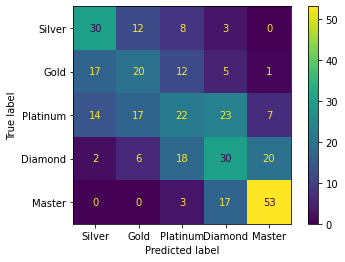

In [ ]:
plot_heatmap(y_test, predicted_labels_test.numpy())


Random Forest Confustion Matrix


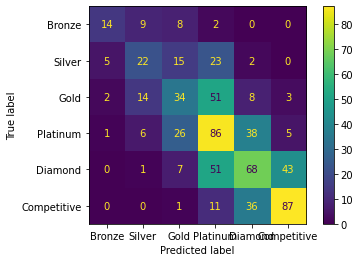


Logistic Regressor Confustion Matrix


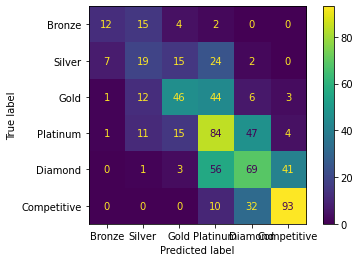

In [35]:
print('\nRandom Forest Confustion Matrix')
plot_heatmap(y_test, best_rfr.predict(X_test))
print('\nLogistic Regressor Confustion Matrix')
plot_heatmap(y_test, best_logreg.predict(X_test))

As we previously mentioned, the confusion matrix provides valuable insights into the performance of a classification model. We note that all 3 models show the same pattern as shown by their respective confusiton matrix:

* The model performs relatively well in predicting the 'Competitive' class, as it correctly predicts most instances of this class, with only a few instances misclassified as 'Platinum'.
* The 'Bronze' class is also predicted quite well, with most instances correctly classified and only a few instances misclassified as 'Silver'.
* The model struggles with the 'Silver' class, as it misclassifies on average 15 instances as 'Gold' and 20 instances as 'Platinum', resulting in a lower accuracy for this class.
* The 'Gold', 'Platinum', and 'Diamond' classes show a pattern of increasing misclassifications as the predicted class moves towards higher levels. For example, 'Gold' is frequently misclassified as 'Platinum' and 'Diamond'.
* The 'Platinum' class exhibits a similar pattern, with many instances misclassified as 'Diamond' and 'Competitive'.
* The 'Diamond' class is frequently misclassified as 'Competitive', 'Platinum', and 'Gold'.

Overall, the confusion matrix suggests that the model struggles with distinguishing between adjacent classes, such as 'Silver' and 'Gold', 'Gold' and 'Platinum', and so on.

#### **Closing Remarks**

In conclusion, it is worth noting that despite using different algorithms and models (logistic regressor, random forest, and neural network), all three models exhibit a similar pattern in their respective confusion matrices. This consistency across the models suggests that the underlying problem or data characteristics may be responsible for the observed pattern in misclassifications.

Identifying the common patterns and sources of misclassifications across the models can provide valuable insights for further analysis and model improvement. It could indicate areas of the dataset that require more attention, feature engineering, or data preprocessing techniques to enhance the model's performance.

Therefore, this observation highlights the importance of thoroughly analyzing the results and patterns across different models to gain a deeper understanding of the data and improve the overall classification performance. It also emphasizes the iterative nature of model development, where insights gained from one model can inform and guide the improvement of subsequent models.